In [1]:
# usual imports

import numpy as np
import random

import os
import scipy.stats as sts
import pandas as pd

import sys
import pickle
from matplotlib import pyplot as plt
sys.path.append('./../packages')
data_path = "../data/"
post_path = "../data/"
from utility import uniquify, reg_log

# from feat_extractor import feature_extract, post_extract 
from hunt import perf_pval, Cij_algo, extract_counts, extract_TS, nbkgmax, nsigmax, count_from_df
from style import le_size, la_size, ti_size, majt_size, mint_size, colormap, color_list, mfixed_labs, figwidth

#### Probed signal stregth and bkg normalizaton

We have 13 bkg events and 8 sig events, which mub and mus space can we study?

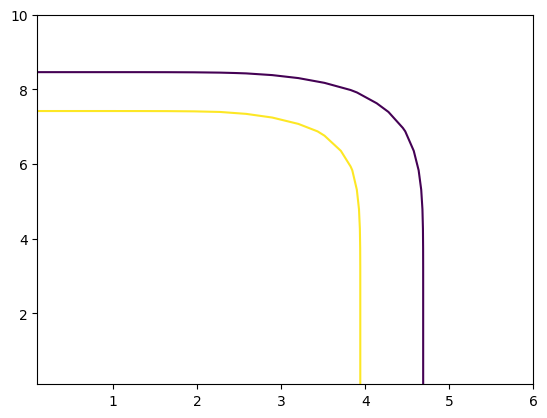

In [2]:
# this can be done independently of how many bkg and sig events we actually have
mubspace_temp = np.linspace(0.1, 10, 20)
musspace_temp = np.linspace(0.1, 6, 20)

bkglist = np.array(range(nbkgmax+1))
siglist = np.array(range(nsigmax+1))

sumprobs = []
for mub in mubspace_temp:
    for mus in musspace_temp:
        probs = sts.poisson(mub).pmf(bkglist).reshape(-1,1)*sts.poisson(mus).pmf(siglist).reshape(1,-1)
        sumprobs.append([mub, mus, np.sum(np.array(probs))])

        mux, muy = np.meshgrid(musspace_temp, mubspace_temp)

plt.contour(mux, muy, np.array(sumprobs)[:,2].reshape([len(mubspace_temp), len(musspace_temp)]), levels = [0.95, 0.98])
plt.show()

So we can consider background strengths up to more than 7 and sig strength up to around 4

## TS distribution

In [3]:
mfixed = 1.
smear = 0

Nobs = 10000 # for fixed nbkg, nsig how many observed samples (related to files used to export the performance), should not be changed
Nsamples = 250000 # for fixed mub, mus how many Poisson samples (large numbers lead to more stable results)

if smear == 0:
    sigs, labsm = [0.001,0.01,0.005, 0.005 ], "small" # small uncertainty case
elif smear == 1:
    sigs, labsm = [0.001,0.05,0.01,  0.01  ], "large" # large uncertainty case


In [4]:
# increase number of spaces for better visualization
mubspace = np.linspace(0.1, 6, 10)
musspace = np.linspace(0.1, 4, 10)

### fixed $\mu_b$, $\mu_s$

In [16]:
bps = 1 # do we sum bkg and signal strength for the bkg hypothesis?
mub = 2
mus = 4

In [17]:
# optimal values for bps = 0 and bps = 1 not necessarily the same 

opt_thro = 0.68
opt_thrp = 0.68

if mfixed == 0.2:
    opt_bin = 4

elif mfixed == 1.:
    opt_bin = 11 
elif mfixed == 4.:
    if smear:
        opt_bin = 30 
    elif smear ==0:
        opt_bin = 48

In [18]:
np.random.seed(42) # this fixed poisson, but not the picking
nbkgsig = np.array([sts.poisson(mub).rvs(Nsamples), sts.poisson(mus).rvs(Nsamples)])
if bps:
    nnurbkg = np.array([sts.poisson(mub+mus).rvs(Nsamples), np.zeros(Nsamples)])
else:
    nnurbkg = np.array([sts.poisson(mub).rvs(Nsamples), np.zeros(Nsamples)])

In [19]:
post = 0 # 0 for ECO, 1 for EPO

labpost="_"
if post:
    labpost = "_post_"

In [20]:
opt_thro = 0.68
opt_thrp = 0.68

if mfixed == 0.2:
    opt_bin = 4

elif mfixed == 1.:
    opt_bin = 11 # could be put differently for small and large
elif mfixed == 4.:
    if smear:
        opt_bin = 30 
    elif smear ==0:
        opt_bin = 48

# we import the counts (already exported) 
with open("../performances/counts/count_bump_"+labsm+"_m_"+str(mfixed)+".pickle", "rb") as fp:  
    countsS = pickle.load(fp)
dfc = pd.DataFrame(countsS, columns=["nbkg", "nsig", "nbins", "counts"])
dfc_opt = dfc.loc[dfc["nbins"]==opt_bin]
countsB_bump, countsS_bump = count_from_df(dfc_opt, nnurbkg, nbkgsig)

with open("../performances/counts/count_cl"+labpost+labsm+"_m_"+str(mfixed)+".pickle", "rb") as fp:  
    countsS = pickle.load(fp)
dfc = pd.DataFrame(countsS, columns=["nbkg", "nsig", "thresh", "counts"])
dfc_opt = dfc.loc[round(dfc["thresh"],2)==np.round(opt_thro,2)]
countsB_ML, countsS_ML = count_from_df(dfc_opt, nnurbkg, nbkgsig)


In [21]:
# the counts can be used to calculate performances
print(perf_pval(countsB_bump, countsS_bump).meanlogp(), perf_pval(countsB_bump, countsS_bump).meansigma())
print(perf_pval(countsB_ML, countsS_ML).meanlogp(), perf_pval(countsB_ML, countsS_ML).meansigma())

1.620303607948875 1.1178933519374534
2.7863715500351436 1.6041979585419792


In [22]:
from scipy.stats import wasserstein_distance

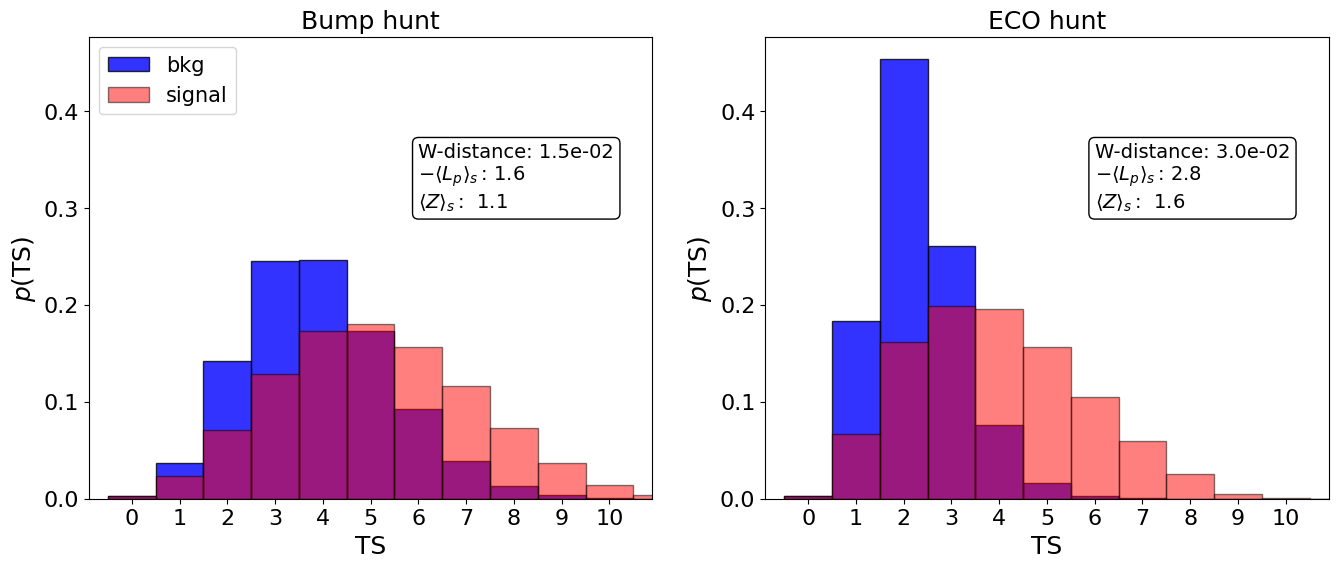

In [28]:
# we plot the counts and mention the performance measures
fig, ax = plt.subplots(ncols=2, figsize=(figwidth,6), sharey=True)

for _ in range(2):
    ax[_].tick_params(axis='both', which='major', labelsize=majt_size)
    ax[_].tick_params(axis='both', which='minor', labelsize=mint_size)
    ax[_].set_xticks(countsS_ML[0]-1, countsS_ML[0]-1)
    ax[_].set_xlim(-0.9,10.9)
ax[0].set_ylabel(r"$p(\text{TS})$", fontsize = la_size)
ax[0].set_xlabel(r"TS", fontsize = la_size)
ax[1].set_ylabel(r"$p(\text{TS})$", fontsize = la_size)
ax[1].set_xlabel(r"TS", fontsize = la_size)

ax[0].bar(countsB_bump[0], countsB_bump[1]/Nsamples, 1, color='blue', edgecolor='black', alpha=0.8, label='bkg')
ax[0].bar(countsS_bump[0], countsS_bump[1]/Nsamples, 1, color='red', edgecolor='black',alpha=0.5, label='signal')
ax[1].bar(countsB_ML[0] , countsB_ML[1] /Nsamples, 1, color='blue', edgecolor='black',alpha=0.8,  label='bkg')
ax[1].bar(countsS_ML[0] , countsS_ML[1] /Nsamples, 1, color='red',edgecolor='black', alpha=0.5, label='signal')


ax[0].text(6, 0.3, r"W-distance: {:.1e}".format(wasserstein_distance(countsB_bump[1]/Nsamples, countsS_bump[1]/Nsamples))+ 
           "\n$-\langle L_p \\rangle_s\,$: " +"{:.1f}".format(perf_pval(countsB_bump, countsS_bump).meanlogp())+
           "\n$\langle Z \\rangle_s\,$:  " +"{:.1f}".format(perf_pval(countsB_bump, countsS_bump).meansigma() ), fontsize=14, bbox=dict(boxstyle="round", fc=(1., 1., 1.)))

ax[1].text(6, 0.3, r"W-distance: {:.1e}".format(wasserstein_distance(countsB_ML[1]/Nsamples, countsS_ML[1]/Nsamples))+ 
           "\n$-\langle L_p \\rangle_s\,$: " +"{:.1f}".format(perf_pval(countsB_ML, countsS_ML).meanlogp())+
           "\n$\langle Z \\rangle_s\,$:  " +"{:.1f}".format(perf_pval(countsB_ML, countsS_ML).meansigma() ) , fontsize=14,bbox=dict(boxstyle="round", fc=(1., 1., 1.)))

ax[1].yaxis.set_tick_params(labelleft=True)
ax[0].set_title("Bump hunt", fontsize = ti_size)
ax[1].set_title("ECO hunt", fontsize=ti_size)
ax[0].legend(fontsize=le_size, loc='upper left')


plt.savefig("../figures/counting_fixed_"+labsm+"_"+str(mfixed)+"_bps.pdf", bbox_inches='tight')

plt.show()

### scan $\mu_b$, $\mu_s$

We now redo the previous step for different bkg normalization and sig strength. 

In [19]:
opt_thro = 0.68
opt_thrp = 0.68

# from before, could be changed at will, new version where opt_thr is introduced externally
if mfixed == 0.2:
    opt_bin = 4

elif mfixed == 1.:
    opt_bin = 11 # could be put differently for small and large

elif mfixed == 4.:
    if smear:
        opt_bin = 30
    elif smear ==0:
        opt_bin = 48

In [20]:
# we parallelize the extraction of p-value, log p-value and Z
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

def TS_par(dfc_opt, mub,mus):
    nbkgsig = np.array([sts.poisson(mub).rvs(Nsamples), sts.poisson(mus).rvs(Nsamples)])
    nnurbkg = np.array([sts.poisson(mub).rvs(Nsamples), np.zeros(Nsamples)]) # this has the same bkg normalization

    countB, countS = count_from_df(dfc_opt, nnurbkg, nbkgsig)

    return([mub, mus, perf_pval(countB, countS).meanp(), perf_pval(countB, countS).meanlogp(), perf_pval(countB, countS).meansigma()])




In [21]:
np.seterr(invalid='ignore') # remove warning divide by 0

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [17]:
# this can take a couple of minutes
# we use the already performed counting to extract the performances and plot them
with open("../performances/counts/count_bump_"+labsm+"_m_"+str(mfixed)+".pickle", "rb") as fp:  
    countsS = pickle.load(fp)
dfc = pd.DataFrame(countsS, columns=["nbkg", "nsig", "nbins", "counts"])
dfc_opt = dfc.loc[dfc["nbins"]==opt_bin]
TS_bump = np.array((Parallel(n_jobs=num_cores)(delayed(TS_par)(dfc_opt, mub, mus) for mub in mubspace for mus in musspace )))

with open("../performances/counts/count_cl_"+labsm+"_m_"+str(mfixed)+".pickle", "rb") as fp:  
    countsS = pickle.load(fp)
dfc = pd.DataFrame(countsS, columns=["nbkg", "nsig", "thresh", "counts"])
dfc_opt = dfc.loc[round(dfc["thresh"],2)==opt_thro]
TS_ECO = np.array((Parallel(n_jobs=num_cores)(delayed(TS_par)(dfc_opt, mub, mus) for mub in mubspace for mus in musspace )))


with open("../performances/counts/count_cl_post_"+labsm+"_m_"+str(mfixed)+".pickle", "rb") as fp:  
    countsS = pickle.load(fp)
dfc = pd.DataFrame(countsS, columns=["nbkg", "nsig", "thresh", "counts"])
dfc_opt = dfc.loc[round(dfc["thresh"],2)==opt_thrp]
TS_EPO = np.array((Parallel(n_jobs=num_cores)(delayed(TS_par)(dfc_opt, mub, mus) for mub in mubspace for mus in musspace )))

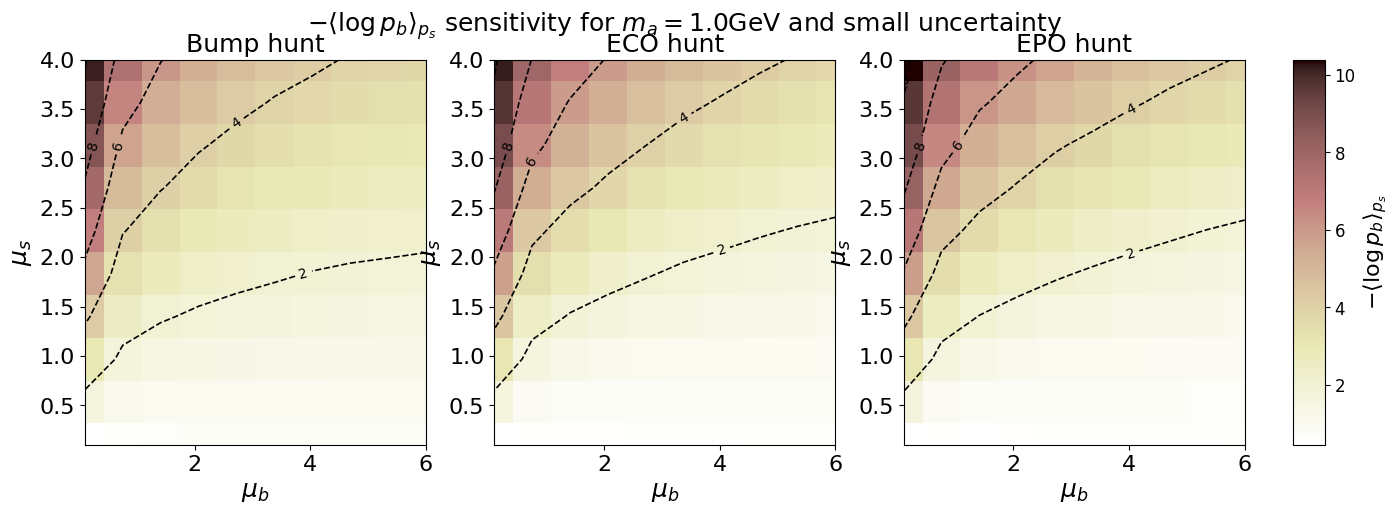

In [18]:
# plot the log p-value
mux, muy = np.meshgrid(musspace, mubspace)

minv, maxv = np.min([np.min(TS_bump[:,3]), np.min(TS_ECO[:,3]), np.min(TS_EPO[:,3])]), np.max([np.max(TS_bump[:,3]), np.max(TS_ECO[:,3]), np.max(TS_EPO[:,3])])
fig, axs = plt.subplots(ncols = 3,  figsize=(16,5), sharey = True)

a0 = axs[0].pcolormesh(muy, mux, (TS_bump[:,3]).reshape([len(mubspace), len(musspace)]), vmin = minv, vmax=maxv, cmap=colormap)
a1 = axs[1].pcolormesh(muy, mux, (TS_ECO[:,3]).reshape([len(mubspace), len(musspace)]), vmin = minv, vmax=maxv, cmap=colormap)
a2 = axs[2].pcolormesh(muy, mux, (TS_EPO[:,3]).reshape([len(mubspace), len(musspace)]), vmin = minv, vmax=maxv, cmap=colormap)

fig.suptitle("$-\langle \log p_b\\rangle_{p_s}$"+" sensitivity for $m_a=${}GeV and ".format(mfixed)+labsm+" uncertainty", fontsize=ti_size)
axs[0].set_title("Bump hunt", fontsize = ti_size)
axs[1].set_title("ECO hunt", fontsize=ti_size)
axs[2].set_title("EPO hunt", fontsize=ti_size)


axs[1].yaxis.set_tick_params(labelleft=True)
axs[2].yaxis.set_tick_params(labelleft=True)

for icol in range(3):
        axs[icol].tick_params(axis='both', which='major', labelsize=majt_size)
        axs[icol].tick_params(axis='both', which='minor', labelsize=mint_size)
        axs[icol].set_ylabel(r"$\mu_s$", fontsize = la_size)
        axs[icol].set_xlabel(r"$\mu_b$", fontsize = la_size)
        axs[icol].set_xlim(mubspace.min(),mubspace.max())
        axs[icol].set_ylim(musspace.min(),musspace.max())

CS = axs[0].contour(muy, mux,  TS_bump[:,3].reshape([len(mubspace), len(musspace)]), levels = [2, 4, 6, 8, 10], colors='black', linestyles='--', linewidths = 1.2)
axs[0].clabel(CS, inline=True, fontsize=10)

CS = axs[1].contour(muy, mux,  TS_ECO[:,3].reshape([len(mubspace), len(musspace)]), levels = [2, 4, 6, 8, 10], colors='black', linestyles='--', linewidths = 1.2)
axs[1].clabel(CS, inline=True, fontsize=10)

CS = axs[2].contour(muy, mux, TS_EPO[:,3].reshape([len(mubspace), len(musspace)]), levels = [2, 4, 6, 8, 10], colors='black', linestyles='--', linewidths = 1.2)
axs[2].clabel(CS, inline=True, fontsize=10)



fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.11, 0.02, 0.77])
cbar = fig.colorbar(a0, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"$-\langle \log p_b\rangle_{p_s}$", fontsize=16)


#plt.savefig("../figures/sensitivity_"+labsm+"_m_"+str(mfixed)+".pdf", bbox_inches='tight')
plt.show()

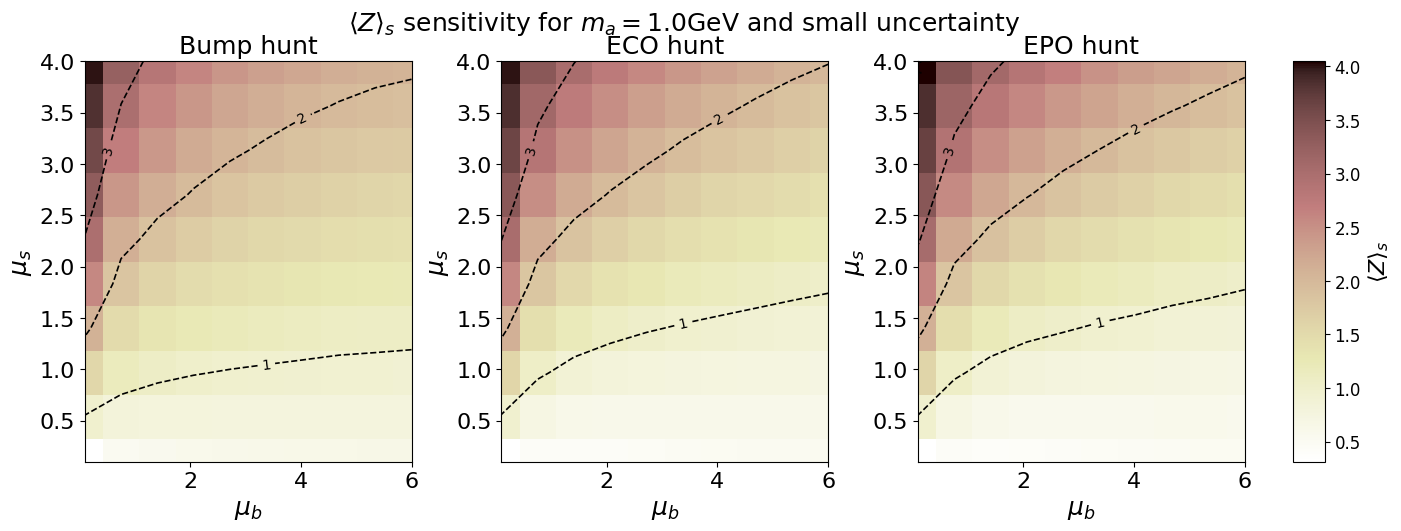

In [19]:
# plot the Z sensitivty
mux, muy = np.meshgrid(musspace, mubspace)

minv, maxv = np.min([np.min(TS_bump[:,4]), np.min(TS_ECO[:,4]), np.min(TS_EPO[:,4])]), np.max([np.max(TS_bump[:,4]), np.max(TS_ECO[:,4]), np.max(TS_EPO[:,4])])
fig, axs = plt.subplots(ncols = 3,  figsize=(figwidth,5.2), sharey = True, gridspec_kw={"wspace": 0.275})

a0 = axs[0].pcolormesh(muy, mux, (TS_bump[:,4]).reshape([len(mubspace), len(musspace)]), vmin = minv, vmax=maxv, cmap=colormap)
a1 = axs[1].pcolormesh(muy, mux, (TS_ECO[:,4]).reshape([len(mubspace), len(musspace)]), vmin = minv, vmax=maxv, cmap=colormap)
a2 = axs[2].pcolormesh(muy, mux, (TS_EPO[:,4]).reshape([len(mubspace), len(musspace)]), vmin = minv, vmax=maxv, cmap=colormap)



fig.suptitle(r"$\langle Z \rangle_s$"+" sensitivity for $m_a=${}GeV and ".format(mfixed)+labsm+" uncertainty", fontsize=ti_size)
axs[0].set_title("Bump hunt", fontsize = ti_size)
axs[1].set_title("ECO hunt", fontsize=ti_size)
axs[2].set_title("EPO hunt", fontsize=ti_size)



axs[1].yaxis.set_tick_params(labelleft=True)
axs[2].yaxis.set_tick_params(labelleft=True)

for icol in range(3):
        axs[icol].tick_params(axis='both', which='major', labelsize=majt_size)
        axs[icol].tick_params(axis='both', which='minor', labelsize=mint_size)
        axs[icol].set_ylabel(r"$\mu_s$", fontsize = la_size)
        axs[icol].set_xlabel(r"$\mu_b$", fontsize = la_size)
        axs[icol].set_xlim(mubspace.min(),mubspace.max())
        axs[icol].set_ylim(musspace.min(),musspace.max())

CS = axs[0].contour(muy, mux,  TS_bump[:,4].reshape([len(mubspace), len(musspace)]), levels = [1,2, 3, 4], colors='black', linestyles='--', linewidths = 1.2)
axs[0].clabel(CS, inline=True, fontsize=10)

CS = axs[1].contour(muy, mux,  TS_ECO[:,4].reshape([len(mubspace), len(musspace)]), levels = [1,2, 3, 4], colors='black', linestyles='--', linewidths = 1.2)
axs[1].clabel(CS, inline=True, fontsize=10)

CS = axs[2].contour(muy, mux,  TS_EPO[:,4].reshape([len(mubspace), len(musspace)]), levels = [1,2, 3, 4], colors='black', linestyles='--', linewidths = 1.2)
axs[2].clabel(CS, inline=True, fontsize=10)



fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.11, 0.02, 0.77])
cbar = fig.colorbar(a0, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"$\langle Z \rangle_s$", fontsize=16)

# plt.savefig("figures/sigmav2_"+labsm+"_m_"+str(mfixed)+".pdf", bbox_inches='tight')
plt.show()

### sensitivity to bin/threshold choice

#### same total number of events

In [54]:
bps = 1 #  do we sum bkg and sig strength for the bkg only hypothesis?

mfixed = 1.
smear = 0

nsig =3
nbkgmax = 5

if smear ==0:
    sigs, labsm, labfig = [0.001,0.01,0.005, 0.005 ], "small", "good" # small uncertainty case
elif smear == 1:
    sigs, labsm, labfig = [0.001,0.05,0.01,  0.01  ], "large", "poor" # large uncertainty case


In [55]:
opt_thro = 0.68
opt_thrp = 0.68

# from before, could be changed at will, new version where opt_thr is introduced externally
if mfixed == 0.2:
    opt_bin = 4

elif mfixed == 1.:
    opt_bin = 11 # could be put differently for small and large

elif mfixed == 4.:
    if smear:
        opt_bin = 30 
    elif smear ==0:
        opt_bin = 48

In [56]:
labpost = "_" # use ECO
with open("../performances/counts/count_cl"+labpost+labsm+"_m_"+str(mfixed)+".pickle", "rb") as fp:  
    countsS = pickle.load(fp)
dfc = pd.DataFrame(countsS, columns=["nbkg", "nsig", "thr", "counts"])
perf_obs = []
for nbkg in range(nbkgmax+1):
    dfc_sig = dfc.loc[(dfc["nbkg"]==nbkg)*(dfc["nsig"]==nsig)]
    if bps:
        dfc_bkg = dfc.loc[(dfc["nbkg"]==nbkg+nsig)*(dfc["nsig"]==0)]
    else:
        dfc_bkg = dfc.loc[(dfc["nbkg"]==nbkg)*(dfc["nsig"]==0)]
    for thr in np.linspace(0.04, 0.96, 24):
        countsB_obs = np.array(dfc_bkg.loc[np.round(dfc_bkg["thr"],2)==np.round(thr,2)]["counts"])[0]
        countsS_obs = np.array(dfc_sig.loc[np.round(dfc_sig["thr"],2)==np.round(thr,2)]["counts"])[0]
        perf_obs.append([nbkg, nsig, thr, perf_pval(countsB_obs, countsS_obs).meanlogp()])
perf_obs = np.array(perf_obs)

/home/alessandro/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alessandro/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
labpost = "_post_" # use EPO
with open("../performances/counts/count_cl"+labpost+labsm+"_m_"+str(mfixed)+".pickle", "rb") as fp:  
    countsS = pickle.load(fp)
dfc = pd.DataFrame(countsS, columns=["nbkg", "nsig", "thr", "counts"])
perf_post = []
for nbkg in range(nbkgmax+1):
    dfc_sig = dfc.loc[(dfc["nbkg"]==nbkg)*(dfc["nsig"]==nsig)]
    if bps:
        dfc_bkg = dfc.loc[(dfc["nbkg"]==nbkg+nsig)*(dfc["nsig"]==0)]
    else:
        dfc_bkg = dfc.loc[(dfc["nbkg"]==nbkg)*(dfc["nsig"]==0)]
    for thr in np.linspace(0.04, 0.96, 24):
        countsB_obs = np.array(dfc_bkg.loc[np.round(dfc_bkg["thr"],2)==np.round(thr,2)]["counts"])[0]
        countsS_obs = np.array(dfc_sig.loc[np.round(dfc_sig["thr"],2)==np.round(thr,2)]["counts"])[0]
        perf_post.append([nbkg, nsig, thr, perf_pval(countsB_obs, countsS_obs).meanlogp()])
perf_post = np.array(perf_post)

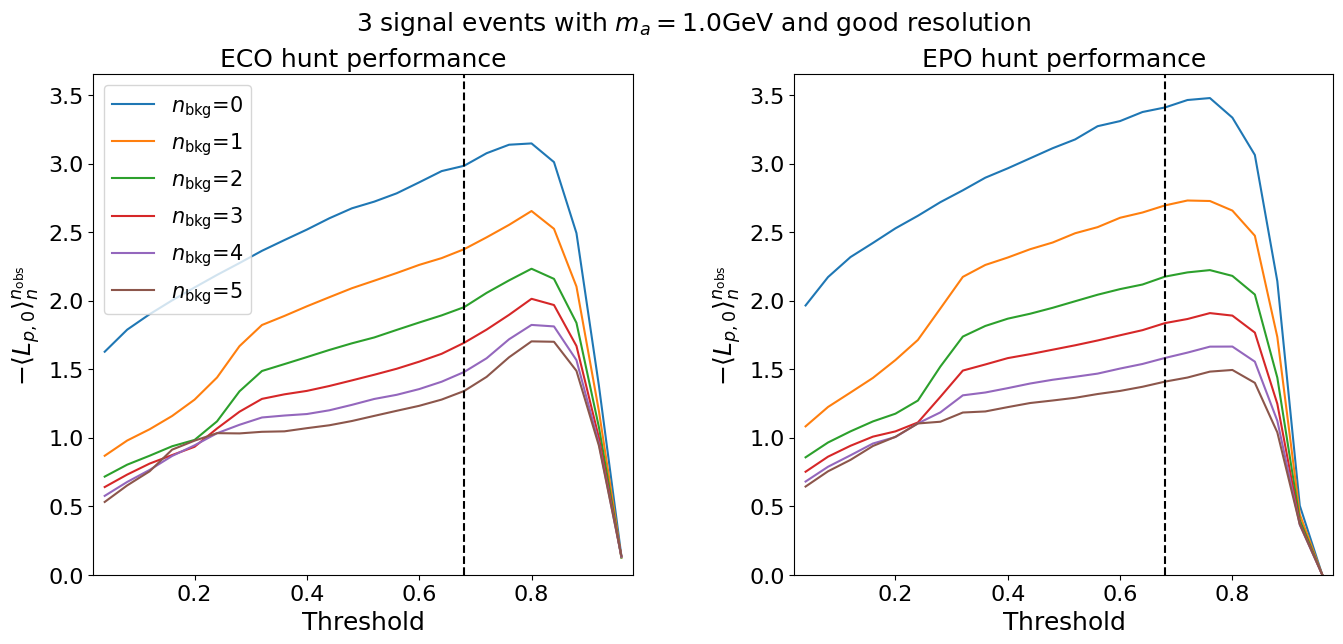

In [58]:
 # we visualize the performance for different scenarios and thresholds
fig, axs = plt.subplots(ncols = 2, figsize=(figwidth,6.5), sharey = True, gridspec_kw={"wspace": 0.3})

for nbkg in [0, 1, 2, 3, 4, 5]:
    #perf_sel = perf_bump[perf_bump[:,0]==nbkg]
    #axs[0].plot(perf_sel[:,2],perf_sel[:,3], label = r"$n_\text{bkg}$="+"{}".format(nbkg))

    perf_sel = perf_obs[perf_obs[:,0]==nbkg]
    axs[0].plot(perf_sel[:,2],perf_sel[:,3], label = r"$n_\text{bkg}$="+"{}".format(nbkg))

    perf_sel = perf_post[perf_post[:,0]==nbkg]
    axs[1].plot(perf_sel[:,2],perf_sel[:,3], label = r"$n_\text{bkg}$="+"{}".format(nbkg))



axs[0].legend(fontsize = le_size)

#axs[0].set_xlim(3,60)
axs[1].set_xlim(0.02,0.98)
axs[0].set_xlim(0.02,0.98)
axs[1].set_ylim(0, axs[1].get_ylim()[1])

fig.suptitle("{} signal events with $m_a=${}GeV and ".format(nsig, mfixed)+labfig+" resolution", fontsize=ti_size)
#axs[0].set_title("Bumphunt performance", fontsize=ti_size)
axs[0].set_title("ECO hunt performance", fontsize=ti_size)
axs[1].set_title("EPO hunt performance", fontsize=ti_size)
axs[0].axvline(opt_thro, color='black', linestyle='--')
axs[1].axvline(opt_thrp, color='black', linestyle='--')

for _ in range(2):
    axs[_].set_ylabel(r"$-\langle L_{p,0} \rangle_n^{n_\text{obs}}$", fontsize = la_size)
    axs[_].set_xlabel(r"$\mathrm{Threshold}$", fontsize = la_size)
    axs[_].tick_params(axis='both', which='major', labelsize=majt_size)
    axs[_].tick_params(axis='both', which='minor', labelsize=mint_size)
    axs[_].yaxis.set_tick_params(labelleft=True)



plt.savefig("../figures/performance_"+labsm+"_s_"+str(nsig)+"_m_"+str(mfixed)+".pdf", bbox_inches='tight')
plt.show()

#### signal on top of background

In [82]:
mubspace = np.linspace(0.5, 6, 12)
musspace = np.linspace(0.5, 4, 8)
print(mubspace)
print(musspace)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]
[0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


In [93]:
mfixed = 0.2
smear = 1

if smear ==0:
    sigs, labsm, labfig = [0.001,0.01,0.005, 0.005 ], "small", "good" # small uncertainty case
elif smear == 1:
    sigs, labsm, labfig = [0.001,0.05,0.01,  0.01  ], "large", "poor" # large uncertainty case

# [thr, mub, mus, p, logp, Z]
perf_ECO = np.loadtxt("../performances/TS/perf_full_cl_"+labsm+"_m_"+str(mfixed)+".csv")
perf_EPO = np.loadtxt("../performances/TS/perf_full_cl_post_"+labsm+"_m_"+str(mfixed)+".csv")


In [94]:
opt_thro = 0.68
opt_thrp = 0.68


# from before, could be changed at will, new version where opt_thr is introduced externally
if mfixed == 0.2:
    opt_bin = 4

elif mfixed == 1.:
    opt_bin = 11 # could be put differently for small and large

elif mfixed == 4.:
    if smear:
        opt_bin = 30 
    elif smear ==0:
        opt_bin = 48
        


In [95]:
# find closest instance of an element
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


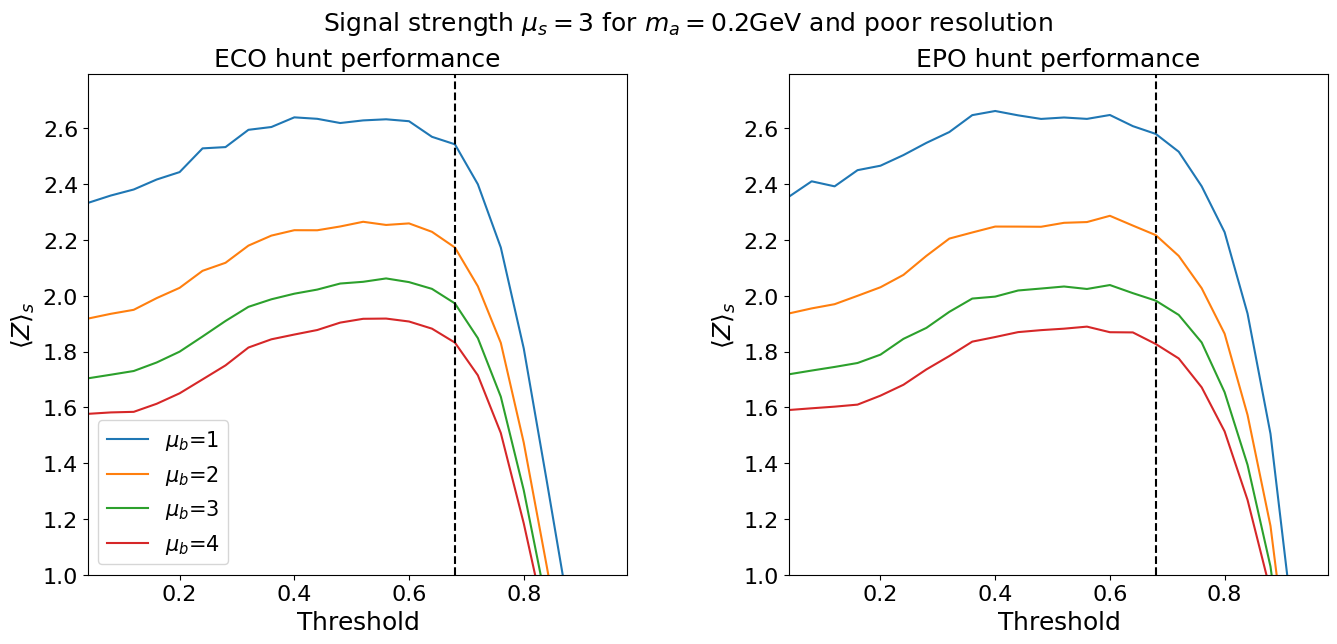

In [96]:
fig, axs = plt.subplots(ncols = 2, figsize=(figwidth,6.5), sharey = True, gridspec_kw={"wspace": 0.3})

mus = 3
for mub in [1, 2, 3, 4]: # we scan over values of the bkg normalization
    

    perf_sel = perf_ECO[(perf_ECO[:,1]==find_nearest(mubspace, mub))*(perf_ECO[:,2]==find_nearest(musspace, mus))]
    axs[0].plot(perf_sel[:,0],perf_sel[:,5], label = r"$\mu_b$="+"{}".format(mub))

    perf_sel = perf_EPO[(perf_EPO[:,1]==find_nearest(mubspace, mub))*(perf_EPO[:,2]==find_nearest(musspace, mus))]
    axs[1].plot(perf_sel[:,0],perf_sel[:,5], label = r"$\mu_b$="+"{}".format(mub))



axs[0].legend(fontsize = le_size)

#axs[0].set_xlim(3,60)
axs[1].set_xlim(0.04,0.98)
axs[0].set_xlim(0.04,0.98)
axs[1].set_ylim(1, axs[1].get_ylim()[1])

fig.suptitle(r"Signal strength $\mu_s=${} for $m_a=${}GeV and ".format(mus, mfixed)+labfig+" resolution", fontsize=ti_size)
#axs[0].set_title("Bumphunt performance", fontsize=ti_size)
axs[0].set_title("ECO hunt performance", fontsize=ti_size)
axs[1].set_title("EPO hunt performance", fontsize=ti_size)
axs[0].axvline(opt_thro, color='black', linestyle='--')
axs[1].axvline(opt_thrp, color='black', linestyle='--')

for _ in range(2):
    axs[_].set_ylabel(r"$\langle  Z \rangle_s$", fontsize = la_size)
    axs[_].set_xlabel(r"$\mathrm{Threshold}$", fontsize = la_size)
    axs[_].tick_params(axis='both', which='major', labelsize=majt_size)
    axs[_].tick_params(axis='both', which='minor', labelsize=mint_size)
    axs[_].yaxis.set_tick_params(labelleft=True)


plt.savefig("../figures/performance_Z_"+labsm+"_s_"+str(mus)+"_m_"+str(mfixed)+".pdf", bbox_inches='tight')
plt.show()